# Minnesota Nice Ride 2016

### The 2016 MN Nice Ride season ran from April 4th, 2016 to November 6th, 2016

In [1]:
import datetime
start = datetime.date(2016,4,4)
# set out one extra day to ensure last day of the season is included
end = datetime.date(2016,11,7); delta = end-start
print('The 2016 MN Nice Ride season encompassed {0} days.'.format(delta.days))

The 2016 MN Nice Ride season encompassed 217 days.


From the officially released data: 

>The fields for **bike rentals** are as follows:
> 1. **Start date** (Date and time the rental began)
2. **Start station** (Descriptive name for the station where the rental began, changes if station is moved)
3. **Start terminal** (Logical name for the station/terminal where the rental began, does not change when station is moved)
4. **End date** (Date and time the rental ended)
5. **End station** (descriptive name for the station where the rental ended)
6. **End terminal** (Logical name for the station/terminal where the rental ended)
7. **Total duration** (Seconds) ( total length of the rental in seconds) 
8. **Account type** (Members have an account with Nice Ride, Casuals purchase a pass at the station)

>The fields for **stations** are as follows:
>1. **Terminal** (Logical name of station – matches Start terminal / End terminal in trip history)
2. **Station** (Station name used on maps, xml feed and station poster frame – matches Start station / End station  in trip history)
3. **Latitude** (Station location decimal latitude)
4. **Longitude** (Station location decimal longitude)
5. **Nb Docks** (Total number of bike docking points at station – indicates station size)<br>
Stations that have moved during the season or were installed late in the season may also be noted in this document.


### Basic Jupyter Notebook data

In [2]:
%reload_ext watermark
%watermark -a 'Author: James Larkin' 
print ''
%watermark -u -n -t -z
print ''
%watermark -g

Author: James Larkin

last updated: Wed May 31 2017 01:04:38 EDT

Git hash: 77ec777c26129af9f8764a7efb38e73972b22202


### Load libraries and modules

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from __future__ import division
from datetime import datetime, timedelta
from dateutil import relativedelta
import calendar
from OutlierModule import outliers
from IPython.display import Image, HTML
import re
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Read in data for analysis

In [4]:
mn_complete = pd.read_csv('Data/ride_station_complete.csv',
                          parse_dates=['Start date', 'End date'],
                          infer_datetime_format=True)

### Overview of the dataset as a whole

In [5]:
mn_complete.info()
#mn_complete.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432283 entries, 0 to 432282
Data columns (total 20 columns):
Start date                  432274 non-null datetime64[ns]
Start station               432274 non-null object
Start terminal              432274 non-null object
Start City                  432274 non-null object
Start Neighborhood          432274 non-null object
Start Zip                   432274 non-null float64
Start CPED                  432274 non-null object
Start Council Ward          432274 non-null float64
Start Number Docks          432274 non-null float64
End date                    432274 non-null datetime64[ns]
End station                 432274 non-null object
End terminal                432274 non-null object
End City                    432274 non-null object
End Neighborhood            432274 non-null object
End Zip                     432274 non-null float64
End CPED                    432274 non-null object
End Council Ward            432274 non-null float64
E

In [6]:
mn_complete.dtypes.value_counts()

object            11
float64            6
datetime64[ns]     2
int64              1
dtype: int64

In [7]:
#Memory usage does not include memory consumed by elements
#that are not components of the array if deep=False
print('Total bytes: {0} and Total MB: {1}\n'
      .format(mn_complete.memory_usage(deep=True).sum(),
              int(mn_complete.memory_usage(deep=True).sum()/1048576)))
print(mn_complete.memory_usage(deep=True))

Total bytes: 293812400 and Total MB: 280

Index                             72
Start date                   3458264
Start station               29433351
Start terminal              16783669
Start City                  24095051
Start Neighborhood          25223344
Start Zip                    3458264
Start CPED                  24500002
Start Council Ward           3458264
Start Number Docks           3458264
End date                     3458264
End station                 29419812
End terminal                17373794
End City                    24095441
End Neighborhood            25221182
End Zip                      3458264
End CPED                    24496041
End Council Ward             3458264
End Number Docks             3458264
Total duration (seconds)     3458264
Account type                22046265
dtype: int64


In [8]:
mn_complete._data

BlockManager
Items: Index([u'Start date', u'Start station', u'Start terminal', u'Start City',
       u'Start Neighborhood', u'Start Zip', u'Start CPED',
       u'Start Council Ward', u'Start Number Docks', u'End date',
       u'End station', u'End terminal', u'End City', u'End Neighborhood',
       u'End Zip', u'End CPED', u'End Council Ward', u'End Number Docks',
       u'Total duration (seconds)', u'Account type'],
      dtype='object')
Axis 1: RangeIndex(start=0, stop=432283, step=1)
FloatBlock: [5, 7, 8, 14, 16, 17], 6 x 432283, dtype: float64
IntBlock: slice(18, 19, 1), 1 x 432283, dtype: int64
DatetimeBlock: slice(0, 18, 9), 2 x 432283, dtype: datetime64[ns]
ObjectBlock: [1, 2, 3, 4, 6, 10, 11, 12, 13, 15, 19], 11 x 432283, dtype: object

In [9]:
objects = mn_complete.select_dtypes(['object'])
objects_memory = objects.memory_usage(deep=True)
obj_memory_total = (objects_memory.sum()/1048576)
print('True MB used to store the strings in the object columns is roughly {0} MB.'
      .format(int(obj_memory_total)))

True MB used to store the strings in the object columns is roughly 250 MB.


**Since many of these object strings are actually numbers, may wish to review dtype changes to reduce memory usage and potentially increase performance should code blocks lag.**

In [10]:
mn_complete.shape

(432283, 20)

In [11]:
mn_complete.head(3)

,Start date,Start station,Start terminal,Start City,Start Neighborhood,Start Zip,Start CPED,Start Council Ward,Start Number Docks,End date,End station,End terminal,End City,End Neighborhood,End Zip,End CPED,End Council Ward,End Number Docks,Total duration (seconds),Account type
0,2016-11-06 22:09:00,Willey Hall,30195,Minneapolis,University of MN,55414.0,Minn-East,2.0,23.0,2016-11-06 22:14:00,McNamara Center,30057,Minneapolis,University of MN,55455.0,Minn-East,2.0,19.0,325,Casual
1,2016-11-06 21:53:00,Sanford Hall,30182,Minneapolis,University of MN,55414.0,Minn-East,3.0,23.0,2016-11-06 21:59:00,McNamara Center,30057,Minneapolis,University of MN,55455.0,Minn-East,2.0,19.0,315,Member
2,2016-11-06 21:52:00,11th Ave S & S 2nd Street,30154,Minneapolis,Downtown East,55415.0,Minn-Downtown,7.0,23.0,2016-11-06 22:17:00,Malcolm Ave SE & 5th Street SE,30055,Minneapolis,Prospect Park/East River Road,55414.0,Minn-East,2.0,24.0,1504,Casual


In [12]:
mn_complete.sample(3)

,Start date,Start station,Start terminal,Start City,Start Neighborhood,Start Zip,Start CPED,Start Council Ward,Start Number Docks,End date,End station,End terminal,End City,End Neighborhood,End Zip,End CPED,End Council Ward,End Number Docks,Total duration (seconds),Account type
363340,2016-05-20 12:06:00,10th Street E & Cedar Street,30117,St. Paul,St. Paul Downtown,55101.0,St. Paul Downtown,2.0,15.0,2016-05-20 12:24:00,Dale Street & Grand Ave.,30106,St. Paul,Summit Hill,55102.0,St. Paul Central,1.0,15.0,1083,Casual
54976,2016-09-29 19:19:00,9th Street & 4th Ave,30007,Minneapolis,Downtown West,55404.0,Minn-Downtown,7.0,19.0,2016-09-29 19:21:00,Grant Street & Portland Ave,30087,Minneapolis,Elliot Park,55404.0,Minn-Downtown,7.0,15.0,144,Member
400833,2016-04-29 17:29:00,11th Street & Hennepin,30004,Minneapolis,Downtown West,55403.0,Minn-Downtown,7.0,23.0,2016-04-29 17:45:00,University Ave. NE & 12th Ave. NE,30096,Minneapolis,Sheridan,55413.0,Minn-East,3.0,15.0,927,Casual


In [13]:
mn_complete.columns

Index([u'Start date', u'Start station', u'Start terminal', u'Start City',
       u'Start Neighborhood', u'Start Zip', u'Start CPED',
       u'Start Council Ward', u'Start Number Docks', u'End date',
       u'End station', u'End terminal', u'End City', u'End Neighborhood',
       u'End Zip', u'End CPED', u'End Council Ward', u'End Number Docks',
       u'Total duration (seconds)', u'Account type'],
      dtype='object')

### Rename columns in snake_case for easier typing

In [14]:
def column_cleanup(col):
    col = re.sub(r"[^\w\s]", '', col)
    col = re.sub(r"\s+", '_', col).lower()
    return col
mn_complete = mn_complete.rename(columns=column_cleanup)

### Pickle the MN Nice Ride 2016 season data

In [15]:
mn_complete.to_pickle('nice.pkl')

In [16]:
mn_complete = pd.read_pickle('nice.pkl')

### Check if there are any nulls in the dataset

In [17]:
complete = mn_complete.notnull().sum() * 100.0/mn_complete.shape[0]
print("Percentage complete for each \nMN Nice Ride 2016 column: \n{0}".format(complete))

Percentage complete for each 
MN Nice Ride 2016 column: 
start_date                 99.997918
start_station              99.997918
start_terminal             99.997918
start_city                 99.997918
start_neighborhood         99.997918
start_zip                  99.997918
start_cped                 99.997918
start_council_ward         99.997918
start_number_docks         99.997918
end_date                   99.997918
end_station                99.997918
end_terminal               99.997918
end_city                   99.997918
end_neighborhood           99.997918
end_zip                    99.997918
end_cped                   99.997918
end_council_ward           99.997918
end_number_docks           99.997918
total_duration_seconds    100.000000
account_type               99.997918
dtype: float64


In [18]:
mn_complete.apply(lambda x: sum(x.isnull()), axis=0)

start_date                9
start_station             9
start_terminal            9
start_city                9
start_neighborhood        9
start_zip                 9
start_cped                9
start_council_ward        9
start_number_docks        9
end_date                  9
end_station               9
end_terminal              9
end_city                  9
end_neighborhood          9
end_zip                   9
end_cped                  9
end_council_ward          9
end_number_docks          9
total_duration_seconds    0
account_type              9
dtype: int64

**Found nine rows with nulls or missing values in the original data release. No real information to work off of to consider further research and possible imputation. As those missing rows make up ≈0.002% of the dataset, I will drop nulls and move forward with the analysis.**

In [19]:
mn_complete.dropna(inplace=True); mn_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 432274 entries, 0 to 432282
Data columns (total 20 columns):
start_date                432274 non-null datetime64[ns]
start_station             432274 non-null object
start_terminal            432274 non-null object
start_city                432274 non-null object
start_neighborhood        432274 non-null object
start_zip                 432274 non-null float64
start_cped                432274 non-null object
start_council_ward        432274 non-null float64
start_number_docks        432274 non-null float64
end_date                  432274 non-null datetime64[ns]
end_station               432274 non-null object
end_terminal              432274 non-null object
end_city                  432274 non-null object
end_neighborhood          432274 non-null object
end_zip                   432274 non-null float64
end_cped                  432274 non-null object
end_council_ward          432274 non-null float64
end_number_docks          432274 no

### Overview of ride data by city

In [20]:
f = pd.DataFrame(mn_complete.start_city.value_counts().sort_values(ascending=False))
f = f.rename(columns={'start_city':'starts'});
g = pd.DataFrame(mn_complete.start_city.value_counts()/mn_complete.start_city.value_counts().sum())
g = g*100; g = g.rename(columns={'start_city':'% of total'})
city_start = pd.concat([f, g], axis=1); print(city_start)
print('Total        {0}'.format(mn_complete.start_city.value_counts().sum()))

             starts  % of total
Minneapolis  394747   91.318701
St. Paul      37527    8.681299
Total        432274


In [21]:
h = pd.DataFrame(mn_complete.end_city.value_counts().sort_values(ascending=False))
h = h.rename(columns={'end_city':'ends'});
i = pd.DataFrame(mn_complete.end_city.value_counts()/mn_complete.end_city.value_counts().sum())
i = i*100; i = i.rename(columns={'end_city':'% of total'})
city_end = pd.concat([h, i], axis=1); print(city_end)
print('Total        {0}'.format(mn_complete.end_city.value_counts().sum()))

               ends  % of total
Minneapolis  394877   91.348774
St. Paul      37397    8.651226
Total        432274


**Clearly, the vast majority of the rides take place in Minneapolis at this point.**

**Only 130 ride (≈0.03%) difference between starts and destinations in each city, but let's explore/verify how many rides actually began on one side of the river and ended on the other.**

In [22]:
#river = pd.DataFrame(list(mn_complete[mn_complete.start_city != mn_complete.end_city].index))
river_crossing = pd.DataFrame(mn_complete[mn_complete.start_city != mn_complete.end_city])

In [23]:
print('The number of Nice Rides that began and ended on different sides of the river is {0:,.0f}.\n'
      .format(len(river_crossing)))
print('A mere {0}% of the Nice Rides in 2016 ended in a different city that it began.'
      .format(round(len(river_crossing)/mn_complete.start_city.value_counts().sum() * 100,2)))

The number of Nice Rides that began and ended on different sides of the river is 10,036.

A mere 2.32% of the Nice Rides in 2016 ended in a different city that it began.


In [24]:
river_grouping = mn_complete.groupby(['start_city', 'end_city']).size()
river_grouping

start_city   end_city   
Minneapolis  Minneapolis    389794
             St. Paul         4953
St. Paul     Minneapolis      5083
             St. Paul        32444
dtype: int64

In [25]:
#unstack -1 or -2 depending on preferred prespective
mn_complete.groupby(['start_city', 'end_city']).size().unstack(-1)

end_city,Minneapolis,St. Paul
start_city,,
Minneapolis,389794,4953
St. Paul,5083,32444


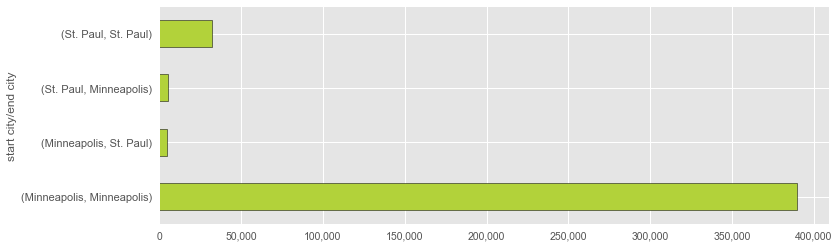

In [26]:
plt.gca().invert_yaxis()
mn_complete.groupby(['start_city', 'end_city']).size().plot(kind='barh', stacked=True,
                                                            figsize=[12, 4],
                                                            color='#B2D23A',
                                                            edgecolor='#000000')
plt.ylabel('start city/end city')
plt.yticks(fontsize=11)
plt.xticks([0, 50000, 100000, 150000, 200000, 250000, 300000,
            350000, 400000],
           ['0', '50,000', '100,000', '150,000', '200,000',
            '250,000', '300,000', '350,000', '400,000'], fontsize=10.5);

### The user breakdown of those rides across the mighty Mississippi

In [27]:
g = mn_complete.groupby([mn_complete.account_type, mn_complete.start_city, mn_complete.end_city])
g.size()
#u = mn_complete.groupby([mn_complete.account_type, mn_complete.month,
#mn_complete.start_city, mn_complete.end_city]); u.size()

account_type  start_city   end_city   
Casual        Minneapolis  Minneapolis    132461
                           St. Paul         1831
              St. Paul     Minneapolis      1752
                           St. Paul        14052
Inconnu       Minneapolis  Minneapolis         2
              St. Paul     St. Paul            1
Member        Minneapolis  Minneapolis    257331
                           St. Paul         3122
              St. Paul     Minneapolis      3331
                           St. Paul        18391
dtype: int64

### Sample stations from where rides started in one city and ended in the other

In [28]:
river_station = river_crossing.groupby(['start_station', 'end_station']).size()

In [29]:
print(river_crossing.start_station.value_counts().head(1)); print
print(river_crossing.start_station.value_counts(1).head(1))

U of M St. Paul Student Center    820
Name: start_station, dtype: int64

U of M St. Paul Student Center    0.081706
Name: start_station, dtype: float64


In [30]:
#23rd Ave SE & 6th Street SE, for example, puts one close to TCF Bank Stadium
# on the campus of the University of Minnesota
print(river_station.loc['U of M St. Paul Student Center'].head(10))

end_station
100 Main Street SE                   2
11th Ave S & S 2nd Street            7
11th Street & Marquette              1
15th Ave SE & 4th Street SE          4
15th Ave SE & Como Ave SE           42
22nd Ave S & Franklin Ave           26
23rd Ave SE & 6th Street SE        120
23rd Ave SE & University Ave SE      6
25th Street & 33rd Ave S            10
27th Ave SE & University Ave.       19
dtype: int64


In [31]:
# Williamson Hall is primarily an administration building for the Univ. of Minnesota
# Top end station is likely due to the Carleton Artist Lofts (popular student housing)
print(river_station.loc['Williamson Hall'])

end_station
Carleton Street & University Ave       64
Curfew Street & Ellis Ave.             36
Dale Street & Grand Ave.                1
Fairview Ave. & University Ave.         1
Grand Ave & Fairview Ave                2
Hamline Ave N & University Ave          1
Lake Como Pavilion                      1
Mississippi River Blvd & Summit Ave     4
Selby Ave & Virginia Street             1
U of M St. Paul Student Center          7
University of St. Thomas                2
dtype: int64


**Could delve even deeper but I expect to find a large percentage of the river crossing rides to involve the transportation of Univeristy of Minnesota students.**

### Overview of account_type data

In [32]:
mn_complete.account_type.value_counts()

Member     282175
Casual     150096
Inconnu         3
Name: account_type, dtype: int64

### Remove Inconnu: French for person unknown

In [33]:
value_list = ['Inconnu']
mn_complete = mn_complete[~mn_complete.account_type.isin(value_list)]

In [34]:
mn_complete.shape

(432271, 20)

In [35]:
mn_complete.columns

Index([u'start_date', u'start_station', u'start_terminal', u'start_city',
       u'start_neighborhood', u'start_zip', u'start_cped',
       u'start_council_ward', u'start_number_docks', u'end_date',
       u'end_station', u'end_terminal', u'end_city', u'end_neighborhood',
       u'end_zip', u'end_cped', u'end_council_ward', u'end_number_docks',
       u'total_duration_seconds', u'account_type'],
      dtype='object')

### Account type breakout by user

In [36]:
ind = pd.DatetimeIndex(mn_complete.start_date)
mn_complete['date'] = ind.date.astype('datetime64')
mn_complete['month'] = ind.month
mn_complete['hour'] = ind.hour

In [37]:
a = pd.DataFrame(mn_complete.account_type.value_counts().sort_values(ascending=False))
a = a.rename(columns={'account_type':'count'});
b = pd.DataFrame(mn_complete.account_type.value_counts()/mn_complete.account_type.value_counts().sum())
b = b*100; b = b.rename(columns={'account_type':'% of total'})
user_breakout = pd.concat([a, b], axis=1);
print(user_breakout);
print('Total   {0}'.format(mn_complete.month.value_counts().sum()))

         count  % of total
Member  282175   65.277338
Casual  150096   34.722662
Total   432271


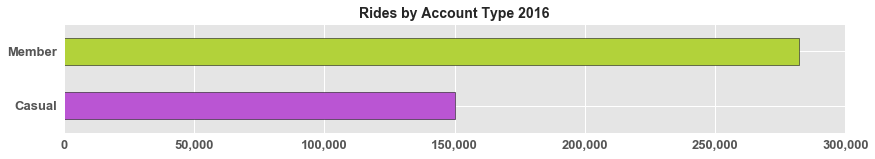

In [38]:
fig = plt.figure(figsize=(14, 2))
ax = fig.gca() #.invert_yaxis()
colors = ['#BA55D3', '#B2D23A']
mn_complete.account_type.value_counts(ascending=True).plot(kind='barh',
                                                   color=colors,
                                                   edgecolor="#000000")
plt.xticks([0, 50000, 100000, 150000, 200000, 250000, 300000],
           ['0', '50,000', '100,000', '150,000','200,000',
            '250,000', '300,000'], fontsize=13, fontweight='bold')
plt.yticks(fontsize=13, fontweight='bold')
plt.title("Rides by Account Type 2016", fontsize=14, fontweight='bold');

### Total Duration (total length of the rental in seconds)

**Creating dataframe with DateTime index for exploration**

In [39]:
mn_time = mn_complete.set_index('start_date')

In [40]:
print('Average Nice Ride trip in seconds: {0}'
      .format(mn_time.total_duration_seconds.mean()))

Average Nice Ride trip in seconds: 1888.92963905


BE ADVISED: Scales are significantly different.


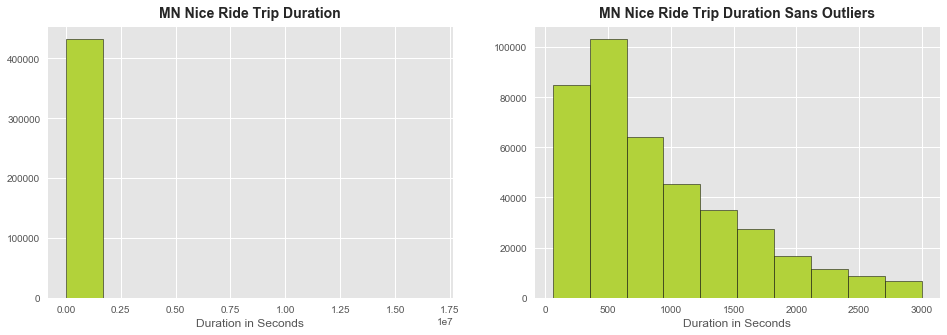

In [41]:
print('BE ADVISED: Scales are significantly different.')
x = mn_time.total_duration_seconds
filtered = x[~outliers.is_outlier(x)]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))
ax1.hist(x, color='#B2D23A', edgecolor="#000000")
ax1.set_title('MN Nice Ride Trip Duration', y=1.01,
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Duration in Seconds')
ax2.hist(filtered, color='#B2D23A', edgecolor="#000000")
ax2.set_title('MN Nice Ride Trip Duration Sans Outliers', y=1.01,
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Duration in Seconds')
plt.show()

In [42]:
#seconds to minutes
mn_time.total_duration_seconds /= 60

In [43]:
print('Average Nice Ride trip: {0:.2f} minutes'
      .format(mn_time.total_duration_seconds.mean()))

Average Nice Ride trip: 31.48 minutes


In [44]:
mn_time.total_duration_seconds.max()

280043.68333333335

In [45]:
minutes = 280043; hour = 60; day = 24
minutes/hour/day

194.47430555555556

BE ADVISED: Scales are significantly different.


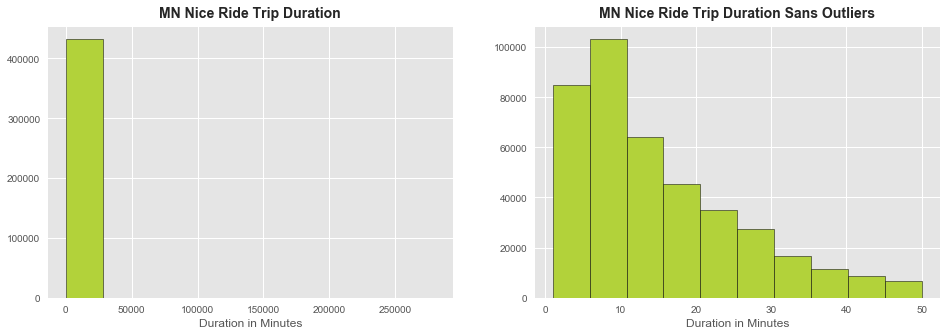

In [46]:
print('BE ADVISED: Scales are significantly different.')
x = mn_time.total_duration_seconds
filtered = x[~outliers.is_outlier(x)]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))
ax1.hist(x, color='#B2D23A', edgecolor="#000000")
ax1.set_title('MN Nice Ride Trip Duration', y=1.01,
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Duration in Minutes')
ax2.hist(filtered, color='#B2D23A', edgecolor="#000000")
ax2.set_title('MN Nice Ride Trip Duration Sans Outliers', y=1.01,
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Duration in Minutes')
plt.show()

In [47]:
print("Maximum Trip Duration: {0:,.0f}"
      .format(stats.scoreatpercentile(mn_time.total_duration_seconds, 100)))
print("Trip Duration 99th percentile: {0:,.0f}"
      .format(stats.scoreatpercentile(mn_time.total_duration_seconds, 99)))
print("Trip Duration 98th percentile: {0:,.0f}"
      .format(stats.scoreatpercentile(mn_time.total_duration_seconds, 98)))
print("Trip Duration 95th percentile: {0:,.0f}"
      .format(stats.scoreatpercentile(mn_time.total_duration_seconds, 95)))

Maximum Trip Duration: 280,044
Trip Duration 99th percentile: 137
Trip Duration 98th percentile: 93
Trip Duration 95th percentile: 58


**At least one massive outlier to address in the data. 280,044 minutes (or nearly 195 days) is seemingly impossible.**<br>**Will need to see if this is an issue with the released dataset or an actual situation that occurred.**

In [48]:
mn_time.loc['2016-04-21 05:52:00'].stack()

start_date                                 
2016-04-21 05:52:00  start_station             Dale Street N & University Ave
                     start_terminal                                     30107
                     start_city                                      St. Paul
                     start_neighborhood                     Summit-University
                     start_zip                                          55102
                     start_cped                              St. Paul Central
                     start_council_ward                                     1
                     start_number_docks                                    15
                     end_date                             2016-11-01 17:16:00
                     end_station                      Hague Ave & Dale Street
                     end_terminal                                       30103
                     end_city                                        St. Paul
                    

In [49]:
avg_ride = pd.DataFrame(mn_time.total_duration_seconds.groupby([lambda x: x.month]).mean())
avg_ride = avg_ride.rename(columns={'total_duration_seconds':'avg_duration'})
months = {'month': ['index zero', 'January', 'February', 'March', 'April', 'May', 'June',
                    'July', 'August', 'September','October', 'November', 'December']}
months = pd.DataFrame(months, columns = months)
avg_ride = pd.concat([months, avg_ride], axis=1);
print(avg_ride[4:12])

        month  avg_duration
4       April     41.189599
5         May     37.283610
6        June     32.965073
7        July     33.003814
8      August     29.817043
9   September     25.582072
10    October     22.889583
11   November     21.208528


**April likely skewed significantly by the extreme outlier mentioned above. Quite possible that other outlier rides starting in other months or continued from prior months are skewing the rest of the trip duration data distribution as well.**

In [50]:
# Sort out rides that appear to have lasted longer than a day
mn_time.total_duration_seconds.quantile(0.9985)

1504.1161666667304

In [51]:
# set a break point at 1440 minutes or one day
normal_rides = mn_time[mn_time.total_duration_seconds < 1440];
print('Number of Nice Rides under a day: {0}\n'.format(len(normal_rides)))
print('Average Nice Ride trip sans outliers: {0:.2f} minutes\n'
      .format(normal_rides.total_duration_seconds.mean()))
long_rides = mn_time[mn_time.total_duration_seconds > 1440];
print('Number of Nice Rides of a day or more: {0}'.format(len(long_rides)))

Number of Nice Rides under a day: 431585

Average Nice Ride trip sans outliers: 21.22 minutes

Number of Nice Rides of a day or more: 686


In [52]:
# A shade under .16% of the total rides would be removed
print('Percentage of rides that would be removed at this threshold: {0}%'
      .format(round(len(long_rides)/len(mn_time)*100,2)))

Percentage of rides that would be removed at this threshold: 0.16%


In [53]:
long_rides.total_duration_seconds.groupby([lambda x: x.month]).count()

4      84
5     128
6     102
7     144
8     123
9      45
10     54
11      6
Name: total_duration_seconds, dtype: int64

In [54]:
clean_avg_ride = pd.DataFrame(normal_rides.total_duration_seconds.groupby([lambda x: x.month]).mean())
clean_avg_ride = clean_avg_ride.rename(columns={'total_duration_seconds':'avg_duration'})
clean_avg_ride = pd.concat([months, clean_avg_ride], axis=1)
print(clean_avg_ride[4:12])

        month  avg_duration
4       April     21.138272
5         May     23.127233
6        June     21.211216
7        July     22.607627
8      August     21.546594
9   September     19.592706
10    October     17.895202
11   November     19.337248


**Removal of small percentage of rides with a duration of a day or more smoothes out the average trip time.<br>Still a noticable decline in the mean ride duration with the arrival of fall.**

In [55]:
# Can verify idea above by peeking at average trip duration
# (sans outliers) for each week of the season
normal_rides.total_duration_seconds.groupby([lambda x: x.week]).mean()

14    17.365280
15    24.793531
16    20.481544
17    20.299725
18    22.767635
19    18.998036
20    24.299251
21    22.529196
22    22.735435
23    21.782105
24    21.289701
25    21.722085
26    22.736104
27    23.214063
28    23.076178
29    20.898310
30    20.885440
31    21.823138
32    21.816975
33    22.228016
34    21.711687
35    22.788519
36    20.618041
37    19.103677
38    16.910494
39    18.770500
40    17.918459
41    17.260517
42    18.078392
43    14.446188
44    18.560481
Name: total_duration_seconds, dtype: float64

### Suss out which day of the week rides take place

In [56]:
#mn_complete['weekday'] = df.index.weekday
mn_complete.weekday = mn_complete.start_date.dt.dayofweek

In [57]:
mn_complete['day_of_week'] = pd.Series(mn_complete.weekday)

In [58]:
#The day of the week with Monday=0, Sunday=6
x = pd.DataFrame(mn_complete.weekday.value_counts().sort_values(ascending=False))
x = x.rename(columns={'start_date':'count'});
y = pd.DataFrame(mn_complete.weekday.value_counts()/mn_complete.weekday.value_counts().sum())
y = y*100; y = y.rename(columns={'start_date':'% of total'})
z = pd.DataFrame(y.sort_index().pct_change()*100)
z = z.rename(columns={'% of total':'pct change'});

In [59]:
days = {'day': ['Monday', 'Tuesday', 'Wednesday','Thursday',
                'Friday', 'Saturday','Sunday']}
days = pd.DataFrame(days, columns = days)

In [60]:
#The day of the week with Monday=0, Sunday=6
day_breakout = pd.concat([days, x, y, z], axis=1); print(day_breakout)
print
print('Total rides {0}\n'.format(mn_complete.weekday.value_counts().sum()))

         day  count  % of total  pct change
0     Monday  60046   13.890823         NaN
1    Tuesday  55660   12.876182   -7.304400
2  Wednesday  57610   13.327288    3.503414
3   Thursday  57072   13.202829   -0.933866
4     Friday  62056   14.355809    8.732829
5   Saturday  70163   16.231253   13.064007
6     Sunday  69664   16.115816   -0.711201

Total rides 432271



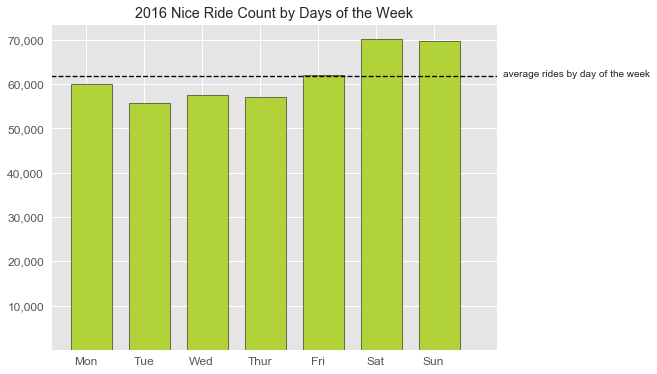

In [121]:
fig = plt.figure(figsize=(8, 6))
plt.gca()
plt.xticks([0, 1, 2, 3, 4, 5, 6], 
           ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'], fontsize=12)
plt.yticks([10000, 20000, 30000, 40000, 50000, 60000, 70000],
           ['10,000', '20,000', '30,000', '40,000', '50,000',
            '60,000', '70,000'], fontsize=12)
plt.hist(mn_complete.day_of_week, bins=np.arange(8)-0.25,
         width=0.70, color='#B2D23A', edgecolor='#000000')
avg = mn_complete.weekday.value_counts().mean()
plt.axhline(y=avg, color='000000', label='Average',
            linestyle='--', linewidth=1.33)
plt.text(7.20, avg, 'average rides by day of the week', rotation=0)
plt.title("2016 Nice Ride Count by Days of the Week");

### Ride count by day of the week and account type

In [62]:
#The day of the week with Monday=0, Sunday=6
w = mn_complete.groupby([mn_complete.account_type, mn_complete.day_of_week])
w.size()

account_type  day_of_week
Casual        0              17527
              1              12318
              2              12569
              3              13149
              4              19345
              5              38282
              6              36906
Member        0              42519
              1              43342
              2              45041
              3              43923
              4              42711
              5              31881
              6              32758
dtype: int64

**Interesting to see casual ridership explode on the weekend while the members tail off after the work week.**
**On weekdays, members can outnumber casual riders by over three to one.** 

### Aggregate weekend ridership by account type

In [63]:
mn_complete['weekend'] = (ind.dayofweek > 4)
weekend_riders = mn_complete.groupby([mn_complete.account_type, mn_complete.weekend])
weekend_riders.size()

account_type  weekend
Casual        False       74908
              True        75188
Member        False      217536
              True        64639
dtype: int64

In [64]:
#The day of the week with Monday=0, Sunday=6
Tue = mn_complete.day_of_week.value_counts().sort_index()[1]
Sat = mn_complete.day_of_week.value_counts().sort_index()[5]
print('Average difference between the busiest and least busy day was roughly {0} rides per week.'
      .format(int((Sat-Tue)/delta.days)))

Average difference between the busiest and least busy day was roughly 66 rides per week.


**Likely to no one's surprise, more rides took place on Saturday and Sunday than on days of the standard work week.<br> That said, a mere 66 ride per week difference between busiest and least busy day of the week was much lower than I expected.**

In [65]:
rides = mn_complete.pivot_table('start_station', index='date',
                              aggfunc='count', columns='account_type', )

MN Nice Ride stations are open 24/7 from April to November.


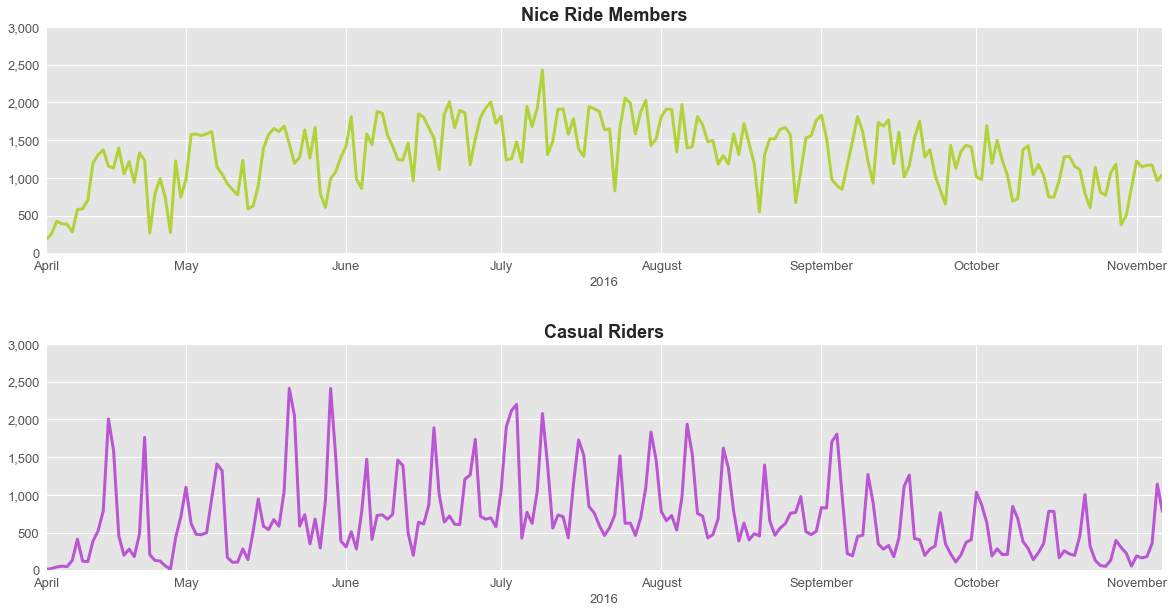

In [66]:
rides2 = rides[['Member', 'Casual']]; rides2
print("MN Nice Ride stations are open 24/7 from April to November.")
fig, ax = plt.subplots(2, figsize=(20, 10))
plt.rcParams['lines.linewidth'] = 3
fig.subplots_adjust(hspace=0.4)
rides2.iloc[:, 0].plot(ax=ax[0], color='#B2D23A')
rides2.iloc[:, 1].plot(ax=ax[1], color='#BA55D3');
ax[0].set_xlabel('2016', y=-1.04, fontsize=13)
ax[1].set_xlabel('2016', fontsize=13)
ax[0].set_ylim([0, 3000])
ax[1].set_ylim([0, 3000])
for axi in ax:
    axi.set_xticklabels(['April', 'May', 'June', 'July', 'August',
                         'September','October', 'November'], fontsize=13)
for axi in ax:
    axi.set_yticklabels(['0', '500', '1,000', '1,500', '2,000', '2,500', '3,000'], fontsize=13)
ax[0].set_title('Nice Ride Members', fontsize=18, fontweight='bold')
ax[1].set_title('Casual Riders', fontsize=18, fontweight='bold');
fig.savefig('Images/usage_trends_2016.png', bbox_inches='tight')

- **Member usage tails off more gradually in the fall than Casual riders.**
- **Member usage has fewer fluctuations and wild swings. Likely due to Casuals riding far less frequently during the work week than during the weekend.**

### Top days for Member rides

In [67]:
#The day of the week with Monday=0, Sunday=6
mem = rides.sort_values('Member', ascending=False)
mem['day'] = mem.index.weekday
print('Members Top Ten \n{0}\n'
      .format(mem.sort_index(by='Member', ascending=[False]).head(10)))
print('Members Bottom Ten \n{0}'
      .format(mem.sort_index(by='Member', ascending=[True]).head(10)))

Members Top Ten 
account_type  Casual  Member  day
date                             
2016-07-09      2078    2427    5
2016-07-25       623    2057    0
2016-07-29      1096    2029    4
2016-06-21       721    2007    1
2016-06-29       696    2003    2
2016-07-26       628    1990    1
2016-08-05       968    1970    4
2016-07-06       769    1946    2
2016-07-18       846    1943    0
2016-07-08      1055    1926    4

Members Bottom Ten 
account_type  Casual  Member  day
date                             
2016-04-04        13     184    0
2016-04-05        26     258    1
2016-04-24       209     265    6
2016-04-28        17     276    3
2016-04-09       133     282    5
2016-10-29       303     380    5
2016-04-08        50     386    4
2016-04-07        56     390    3
2016-04-06        46     425    2
2016-10-30       229     504    6


**The top ten days for total rides by members were quite varied, but interestingly enough only one weekend day was included.**

- **Why no early season heavy use days? (varies from casual top ten dates expressed below)**
- **Members appear to start slow though that could be impacted by membership increasing as the season goes on**

### Top days for Casual riders

In [68]:
#The day of the week with Monday=0, Sunday=6
cas = rides.sort_values('Casual', ascending=False)
cas['day'] = cas.index.weekday
print('Casuals Top Ten \n{0}\n'
      .format(cas.sort_index(by='Casual', ascending=[False]).head(10)))
print('Casuals Bottom Ten \n{0}'
      .format(cas.sort_index(by='Casual', ascending=[True]).head(10)))

Casuals Top Ten 
account_type  Casual  Member  day
date                             
2016-05-29      2411     989    6
2016-05-21      2411    1453    5
2016-07-04      2199    1476    0
2016-07-03      2116    1252    6
2016-07-09      2078    2427    5
2016-05-22      2049    1192    6
2016-04-16      2005    1154    5
2016-08-06      1937    1393    5
2016-07-02      1901    1237    5
2016-06-18      1890    1527    5

Casuals Bottom Ten 
account_type  Casual  Member  day
date                             
2016-04-04        13     184    0
2016-04-28        17     276    3
2016-04-05        26     258    1
2016-04-06        46     425    2
2016-04-08        50     386    4
2016-10-26        54     769    2
2016-04-07        56     390    3
2016-10-31        57     871    0
2016-04-27        59     738    2
2016-10-25        64     809    1


**As one may guess, the top ten days for total rides by casuals were nearly all weekend days. The only expection was a Monday which happened to be the 4th of July.**

- **Interesting to see four top ten days fairly early in the season, including one less than two weeks after launch. Differs significantly from the heavy use days of members.**
- **Do casual riders start their season earlier (though still weekend-focused as the bottom ten show) than members or are the numbers influenced by more individuals signing up for memberships as the season progresses and the weather warms?**

**Neither group started off fast in April. Weather in the Twin Cities can be erratic that time of year. Consider reviewing weather data for the timeframe specifically to see just how cold, snowy, windy April of 2016 may or may not have turned out to be.**

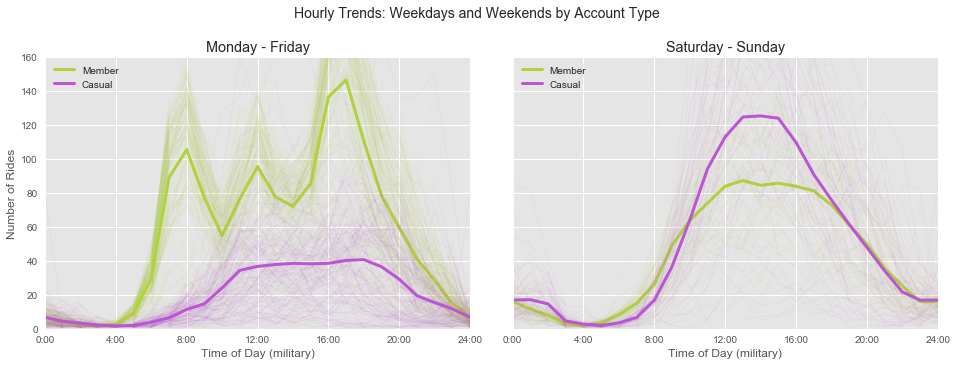

In [69]:
#Code below modified as needed from the following talented individual's github:
#Jake Vanderplus - https://github.com/jakevdp/ProntoData/blob/master/BasicAnalysis.ipynb
#His O'Reilly book is highly recommended 
ind = pd.DatetimeIndex(mn_complete.date); ind.dayofweek
#mn_complete['weekend'] = (ind.dayofweek > 4)
hourly = mn_complete.pivot_table('start_station', aggfunc='count',
                           index=['date'], columns=['account_type', 'weekend', 'hour'])
fig, ax = plt.subplots(1, 2, figsize=(16, 5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1)
fmt = plt.FuncFormatter(lambda x, *args: '{0}:00'.format(int(x)))
color_cycle = plt.rcParams['axes.color_cycle'] = ['#B2D23A', '#BA55D3']

for weekend in (False, True):
    axi = ax[int(weekend)]
    for i, col in enumerate(['Member', 'Casual']):
        vals = hourly[col][weekend].values
        vals = np.hstack([vals, vals[:, :1]])
        #values transformed plotted at slim linewidth
        axi.plot(range(25), vals.T, #alpha set to reduce transparency
                 color=color_cycle[i], lw=1, alpha=0.05)
        #mean (ignoring NaNs) of the values plotted with larger linewidth
        axi.plot(range(25), np.nanmean(vals, 0),
                 color=color_cycle[i], lw=3, label=col)
    axi.xaxis.set_major_locator(plt.MultipleLocator(4))
    axi.xaxis.set_major_formatter(fmt)
    axi.set_ylim(0, 160); axi.set_xlim(0, 24)
    axi.set_title('Saturday - Sunday' if weekend else 'Monday - Friday')
    axi.legend(loc='upper left')
    axi.set_xlabel('Time of Day (military)')
ax[0].set_ylabel('Number of Rides')
fig.suptitle('Hourly Trends: Weekdays and Weekends by Account Type', size=14, y=1.02);
fig.savefig('Images/hourly_trend.png', bbox_inches='tight')

> **Weekday:**
- **Weekday ridership peaks for members around the times a rider is likely to be heading to work, to lunch, or returning home.** 
- **Casual ridership slowly picks until about noon. From there it remains flat until after summer sunset.**

> **Weekend:**
- **Weekend ridership is stronger amongst Casuals but both groups follow a similar basic normal distribution throughout the day peaking around 2pm.**

In [70]:
#mn_complete.month.value_counts().index.tolist()
#mn_complete.month.value_counts().keys()
mn_complete.month.value_counts().sort_index()

4     33457
5     62987
6     71714
7     84329
8     69528
9     57310
10    43420
11     9526
Name: month, dtype: int64

In [71]:
#The day of the week with Monday=0, Sunday=6
m = pd.DataFrame(mn_complete.month.value_counts().sort_values(ascending=False))
m = m.rename(columns={'month':'count'});
n = pd.DataFrame(mn_complete.month.value_counts()/mn_complete.month.value_counts().sum())
n = n*100; n = n.rename(columns={'month':'% of total'})
o = pd.DataFrame(n.sort_index().pct_change()*100)
o = o.rename(columns={'% of total':'pct change'})

In [72]:
month_breakout = pd.concat([months, m, n, o], axis=1);
print(month_breakout[4:12])
print
print('Total rides {0}\n'.format(mn_complete.month.value_counts().sum()))

        month    count  % of total  pct change
4       April  33457.0    7.739821         NaN
5         May  62987.0   14.571183   88.262546
6        June  71714.0   16.590056   13.855240
7        July  84329.0   19.508364   17.590708
8      August  69528.0   16.084354  -17.551495
9   September  57310.0   13.257887  -17.572776
10    October  43420.0   10.044625  -24.236608
11   November   9526.0    2.203710  -78.060801

Total rides 432271



Reminder: November only consists of six days of rides


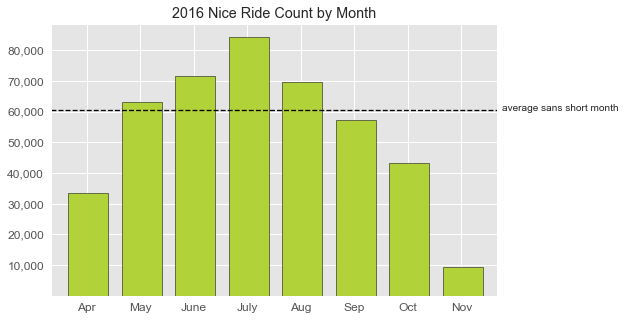

In [122]:
fig = plt.figure(figsize=(8, 5))
plt.gca()
plt.xticks([4, 5, 6, 7, 8, 9, 10, 11], 
           ['Apr', 'May', 'June', 'July', 'Aug',
            'Sep', 'Oct', 'Nov'],fontsize=12)
plt.yticks([10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000],
           ['10,000', '20,000', '30,000', '40,000', '50,000',
            '60,000', '70,000', '80,000'], fontsize=12)
plt.xlim([3.33, 11.67])
pd.Series.hist(mn_complete.month, bins=np.arange(14)-0.35,
               width=0.75, color='#B2D23A', edgecolor='#000000')
sans_nov = mn_complete.month.value_counts().iloc[0:7].mean()
plt.axhline(y=sans_nov, color='000000', label='Average',
            linestyle='--', linewidth=1.33)
plt.text(11.75, sans_nov,'average sans short month', rotation=0)
plt.title("2016 Nice Ride Count by Month")
print("Reminder: November only consists of six days of rides")
plt.title("2016 Nice Ride Count by Month");

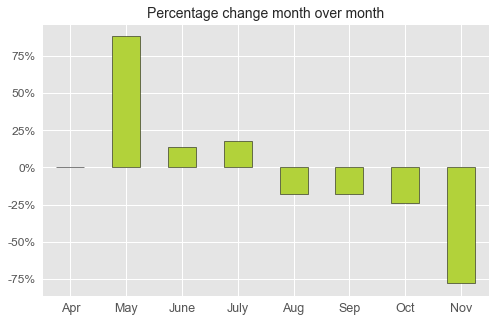

In [74]:
fig, ax = plt.subplots(figsize=(8, 5))
o['pct change'].plot(kind='bar', edgecolor="#000000");
plt.xticks(fontsize=12.5, rotation=0)
group_labels = ['Apr', 'May', 'June', 'July', 'Aug',
            'Sep', 'Oct', 'Nov']
ax.set_xticklabels(group_labels)
plt.yticks([75, 50, 25, 0, -25, -50, -75],
           ['75%', '50%', '25%', '0%', '-25%',
            '-50%', '-75%'], fontsize=12)
plt.title('Percentage change month over month', fontsize=14);

- **Monthly ride count rises sharply after the opening month as the weather warms in May.**
- **Monthly ride count peaks in July and declines steadily until the season closes.**
- **The 2016 season ended on November 6th so that percentage change from October is quite exaggerated**

### Nice Rides by broken out by Account Type as well as Month

In [75]:
nice_members = mn_complete[mn_complete['account_type'] != 'Casual']
nice_casuals = mn_complete[mn_complete['account_type'] != 'Member']

In [76]:
months = {'2016': ['-', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']}
months = pd.DataFrame(months, columns=months);

In [77]:
m = pd.DataFrame(nice_members.month.value_counts())
m = m.rename(columns={'month':'Member Rides'})
c = pd.DataFrame(nice_casuals.month.value_counts())
c = c.rename(columns={'month':'Casual Rides'})
total = pd.DataFrame(mn_complete.month.value_counts().sort_index());
total = total.rename(columns={'month':'Total Rides'})
x = pd.concat([months, m, c, total], axis=1)

In [78]:
x = x.set_index('2016')
x = x.drop(['-', 'Jan', 'Feb', 'Mar', 'Dec'])
x['Member Rides'] = x['Member Rides'].astype(int)
x['Casual Rides'] = x['Casual Rides'].astype(int)
x['Total Rides'] = x['Total Rides'].astype(int)
#t = mn_complete.groupby([mn_complete.account_type, mn_complete.month])
#t.size()

In [79]:
print(x)

      Member Rides  Casual Rides  Total Rides
2016                                         
Apr          22139         11318        33457
May          38088         24899        62987
Jun          47048         24666        71714
Jul          51587         32742        84329
Aug          45493         24035        69528
Sep          39631         17679        57310
Oct          31485         11935        43420
Nov           6704          2822         9526


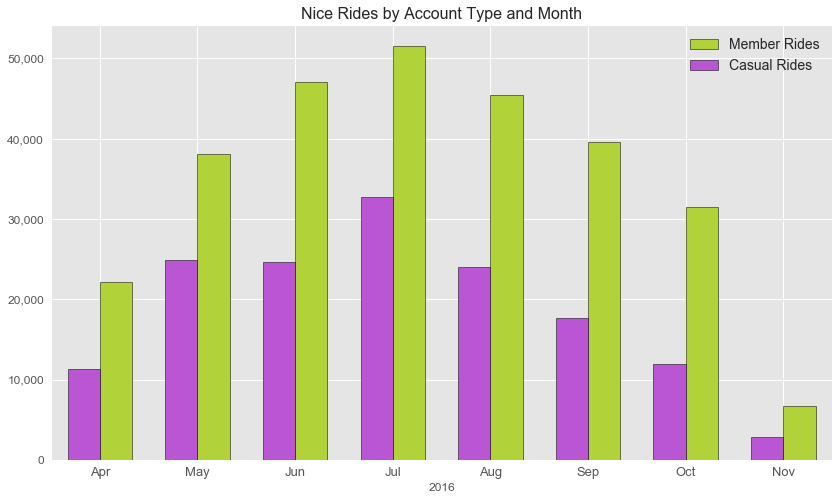

In [80]:
fig, ax = plt.subplots(figsize=(14, 8), sharex=True, sharey=True)
ax2 = sharex=ax

x['Member Rides'].plot(kind='bar', color='#B2D23A',
                       edgecolor="000000", ax=ax, position=0, width=0.33);
x['Casual Rides'].plot(kind='bar', color='#BA55D3',
                       edgecolor="000000", ax=ax2, position=1, width=0.33);
plt.xticks(fontsize=13, rotation='horizontal')
plt.xlim([-.50, 7.50])
plt.yticks([0, 10000, 20000, 30000, 40000, 50000], 
          ['0', '10,000', '20,000', '30,000', '40,000', '50,000'],fontsize=12)
plt.title('Nice Rides by Account Type and Month', size=16)
plt.legend(fontsize=14, loc='best');
fig.savefig('Images/breakout_by_month.png', bbox_inches='tight')

# Weather
**Explore the relationship between the weather and ridership** 

In [81]:
mn_weather = pd.read_csv('Data/MSPAirport_Weather_2016_complete.csv',
                         index_col='DATE', parse_dates=True)

In [82]:
mn_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 217 entries, 2016-04-04 to 2016-11-06
Data columns (total 18 columns):
STATION_NAME                                           217 non-null object
PRECIP                                                 217 non-null float64
TEMP_AVG                                               217 non-null int64
TEMP_MAX                                               217 non-null int64
TEMP_MIN                                               217 non-null int64
AVG_WIND                                               217 non-null float64
WDF2 (Direction of fastest 2 min wind - degrees)       217 non-null int64
WDF5 (Direction of fastest 5 second wind - degrees)    217 non-null int64
WSF2 (Fastest 2 min wind speed)                        217 non-null float64
WSF5 (Fastests 5 second wind speed)                    217 non-null float64
FOG                                                    217 non-null int64
HAIL                                                 

In [83]:
#Memory usage does not include memory consumed by elements
# that are not components of the array if deep=False
print('Total bytes: {0} and Total MB: {1}\n'
      .format(mn_weather.memory_usage(deep=True).sum(),
              int(mn_weather.memory_usage(deep=True).sum()/1048576)))
print(mn_weather.memory_usage(deep=True))

Total bytes: 51212 and Total MB: 0

Index                                                   1736
STATION_NAME                                           19964
PRECIP                                                  1736
TEMP_AVG                                                1736
TEMP_MAX                                                1736
TEMP_MIN                                                1736
AVG_WIND                                                1736
WDF2 (Direction of fastest 2 min wind - degrees)        1736
WDF5 (Direction of fastest 5 second wind - degrees)     1736
WSF2 (Fastest 2 min wind speed)                         1736
WSF5 (Fastests 5 second wind speed)                     1736
FOG                                                     1736
HAIL                                                    1736
HEAVY FOG                                               1736
ICE                                                     1736
SMOKE/HAZE                                       

In [84]:
mn_weather._data

BlockManager
Items: Index([u'STATION_NAME', u'PRECIP', u'TEMP_AVG', u'TEMP_MAX', u'TEMP_MIN',
       u'AVG_WIND', u'WDF2 (Direction of fastest 2 min wind - degrees)',
       u'WDF5 (Direction of fastest 5 second wind - degrees)',
       u'WSF2 (Fastest 2 min wind speed)',
       u'WSF5 (Fastests 5 second wind speed)', u'FOG', u'HAIL', u'HEAVY FOG',
       u'ICE', u'SMOKE/HAZE', u'THUNDER', u'WU (F°) DewPointAvg',
       u'WU % Humidity Avg'],
      dtype='object')
Axis 1: DatetimeIndex(['2016-04-04', '2016-04-05', '2016-04-06', '2016-04-07',
               '2016-04-08', '2016-04-09', '2016-04-10', '2016-04-11',
               '2016-04-12', '2016-04-13',
               ...
               '2016-10-28', '2016-10-29', '2016-10-30', '2016-10-31',
               '2016-11-01', '2016-11-02', '2016-11-03', '2016-11-04',
               '2016-11-05', '2016-11-06'],
              dtype='datetime64[ns]', name=u'DATE', length=217, freq=None)
FloatBlock: [1, 5, 8, 9], 4 x 217, dtype: float64
IntBlock

In [85]:
mn_weather.columns

Index([u'STATION_NAME', u'PRECIP', u'TEMP_AVG', u'TEMP_MAX', u'TEMP_MIN',
       u'AVG_WIND', u'WDF2 (Direction of fastest 2 min wind - degrees)',
       u'WDF5 (Direction of fastest 5 second wind - degrees)',
       u'WSF2 (Fastest 2 min wind speed)',
       u'WSF5 (Fastests 5 second wind speed)', u'FOG', u'HAIL', u'HEAVY FOG',
       u'ICE', u'SMOKE/HAZE', u'THUNDER', u'WU (F°) DewPointAvg',
       u'WU % Humidity Avg'],
      dtype='object')

### Rename the columns for ease of typing

In [86]:
mn_weather = mn_weather.rename(columns={'DATE':'date', 'STATION_NAME':'station_name',
                                        'PRECIP': 'precipitation',
                                        'TEMP_AVG': 'average_temp',
                                        'TEMP_MAX': 'high_temp', 'TEMP_MIN':'low_temp',
                                        'AVG_WIND':'average_wind', 
                                        'WDF2 (Direction of fastest 2 min wind - degrees)': \
                                        'wdf2',
                                        'WDF5 (Direction of fastest 5 second wind - degrees)':\
                                        'wdf5',
                                        'WSF2 (Fastest 2 min wind speed)':'wsf2',
                                        'WSF5 (Fastests 5 second wind speed)':'wsf5',
                                        'FOG':'fog', 'HAIL':'hail',
                                        'HEAVY FOG':'heavy_fog',
                                        'ICE':'ice', 'SMOKE/HAZE':'smoke_haze',
                                        'THUNDER':'thunder',
                                        'WU (F°) DewPointAvg': 'dew_point_avg',
                                        'WU % Humidity Avg': 'humidity_avg'}) 

In [87]:
mn_weather.columns

Index([u'station_name', u'precipitation', u'average_temp', u'high_temp',
       u'low_temp', u'average_wind', u'wdf2', u'wdf5', u'wsf2', u'wsf5',
       u'fog', u'hail', u'heavy_fog', u'ice', u'smoke_haze', u'thunder',
       u'dew_point_avg', u'humidity_avg'],
      dtype='object')

In [88]:
mn_weather.index

DatetimeIndex(['2016-04-04', '2016-04-05', '2016-04-06', '2016-04-07',
               '2016-04-08', '2016-04-09', '2016-04-10', '2016-04-11',
               '2016-04-12', '2016-04-13',
               ...
               '2016-10-28', '2016-10-29', '2016-10-30', '2016-10-31',
               '2016-11-01', '2016-11-02', '2016-11-03', '2016-11-04',
               '2016-11-05', '2016-11-06'],
              dtype='datetime64[ns]', name=u'DATE', length=217, freq=None)

### Check for null values

In [89]:
complete_forecast = mn_weather.notnull().sum() * 100.0/mn_weather.shape[0]
complete_forecast = complete_forecast.round(2); complete_forecast.sort_values()
print("Percentage complete for each \nMN Nice Ride 2016 column: \n{0}"
      .format(complete_forecast))

Percentage complete for each 
MN Nice Ride 2016 column: 
station_name     100.0
precipitation    100.0
average_temp     100.0
high_temp        100.0
low_temp         100.0
average_wind     100.0
wdf2             100.0
wdf5             100.0
wsf2             100.0
wsf5             100.0
fog              100.0
hail             100.0
heavy_fog        100.0
ice              100.0
smoke_haze       100.0
thunder          100.0
dew_point_avg    100.0
humidity_avg     100.0
dtype: float64


In [90]:
mn_weather.apply(lambda x: sum(x.isnull()), axis=0)

station_name     0
precipitation    0
average_temp     0
high_temp        0
low_temp         0
average_wind     0
wdf2             0
wdf5             0
wsf2             0
wsf5             0
fog              0
hail             0
heavy_fog        0
ice              0
smoke_haze       0
thunder          0
dew_point_avg    0
humidity_avg     0
dtype: int64

**Now twice verified full set of weather data. Onward!**

### All weather data is derived from measurements at Minneapolis - St. Paul International Airport
**Will therefore dispense with the station_name column**

In [91]:
mn_weather.drop('station_name', axis=1, inplace=True)

### Other weather columns that will be dropped:
- **Ice has a constant value of zero so there's no variance in the column**
- **Hail only occurred 0.5% percentage of the time. Little variance there.**
- **Heavy Fog only occured 1.8% percentage of the time. Little variance there.**

In [92]:
mn_weather.drop(['ice', 'hail', 'heavy_fog'], axis=1, inplace=True)

In [93]:
print(np.corrcoef(mn_weather.high_temp, mn_weather.average_temp)); print
print(np.corrcoef(mn_weather.low_temp, mn_weather.average_temp)); print
print(np.corrcoef(mn_weather.wsf5, mn_weather.wsf2))

[[ 1.          0.94910719]
 [ 0.94910719  1.        ]]

[[ 1.          0.96773712]
 [ 0.96773712  1.        ]]

[[ 1.          0.96187391]
 [ 0.96187391  1.        ]]


**Due to high correlation with values in other similar columns, high temp, low temp, and wsf5 columns will be dropped as well.**

In [94]:
mn_weather.drop(['high_temp', 'low_temp', 'wsf5'], axis=1, inplace=True)

**Weather data is now better set up for analysis and modeling.**

### The range of the remaining series in the weather dataframe
**Some of the columns are just binaries so the range will only appear as a 1, or possibly a 0 if said weather event never occurred.**

In [95]:
def data_range(series):
    return series.max() - series.min()
data_range(mn_weather)

precipitation      2.17
average_temp      56.00
average_wind      15.60
wdf2             350.00
wdf5             350.00
wsf2              32.00
fog                1.00
smoke_haze         1.00
thunder            1.00
dew_point_avg     62.00
humidity_avg      59.00
dtype: float64

In [96]:
by_date = mn_complete.groupby(['date', 'account_type'])['start_station'].count()   
by_date.name = 'count'    
by_date = by_date.reset_index('account_type').join(mn_weather)
by_date['weekend'] = (by_date.index.dayofweek >= 5)

### Temperature

In [97]:
print('The mean of the daily average temperature of the 2016 season: {:.2f}\n'
      .format(mn_weather.average_temp.mean()))
print('The average daily temperature range for the 2016 season - max of {0} and min of {1}.'
      .format(mn_weather.average_temp.max(), mn_weather.average_temp.min()))


The mean of the daily average temperature of the 2016 season: 64.09

The average daily temperature range for the 2016 season - max of 85 and min of 29.


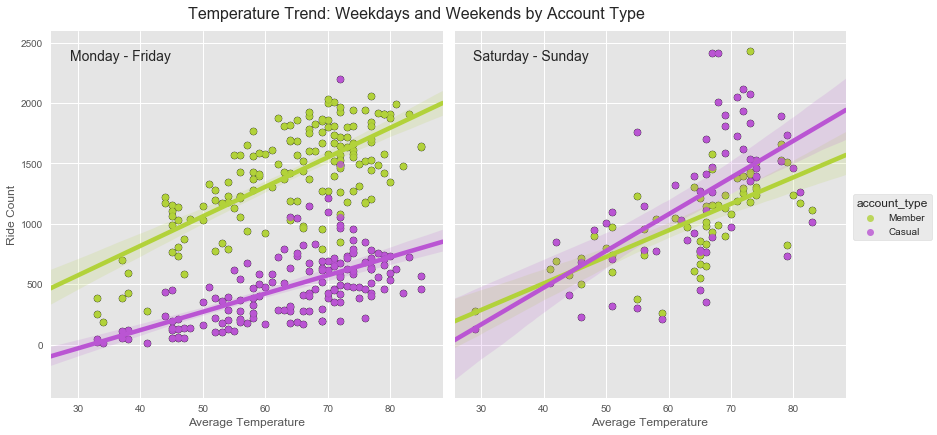

In [98]:
c = dict(Casual='#BA55D3', Member='#B2D23A', set_edgecolor='black')
g = sns.FacetGrid(by_date, col="weekend", hue='account_type',
                  palette=c, hue_order=["Member", "Casual"], size=6)
g.map(plt.scatter, "average_temp", "count", edgecolor="black")
g.map(sns.regplot, "average_temp", "count")
g.add_legend(frameon=True);
#g.axes[0][0].legend(); g.axes[0][1].legend()
g.axes[0, 0].set_title('')
g.axes[0, 1].set_title('')
g.axes[0, 0].text(0.05, 0.95, 'Monday - Friday', va='top', size=14,
                  transform=g.axes[0, 0].transAxes)
g.axes[0, 1].text(0.05, 0.95, 'Saturday - Sunday', va='top', size=14,
                  transform=g.axes[0, 1].transAxes)
g.fig.text(0.45, 1, "Temperature Trend: Weekdays and Weekends by Account Type",
           ha='center', va='top', size=16);
for ax in g.axes.flat:
    ax.set_xlabel('Average Temperature')
g.axes.flat[0].set_ylabel('Ride Count');
g.fig.savefig('Images/temp_trend.png', bbox_inches='tight')

>**Key Points:**
- **As one might expect, warmer temperatures have a general positive impact on ride count for both account types.**
- **Temperature has similar impact on Members regardless of whether one is looking at weekday or weekend ride count.**
- **Temperature has a stronger impact on Casual ridership on the weekends than on weekdays.**
- **Weekend Casual ridership tends to outnumber Member ridership after 50 degrees Fahrenheit.**

### Precipitation

In [99]:
total_prec = mn_weather.precipitation.sum()
print('Total precipitation for the 2016 season is {0} inches'.format(total_prec))

Total precipitation for the 2016 season is 31.52 inches


In [100]:
season=217; avg_precip = total_prec/season; round(avg_precip, 2)

0.15

In [101]:
w = mn_weather.precipitation.value_counts(); w.head()

0.00    137
0.01      6
0.02      5
0.33      4
0.04      3
Name: precipitation, dtype: int64

In [102]:
print('Number of days in the season without any recorded precipitation: {:.2f}%'
      .format(w[0]/season*100))

Number of days in the season without any recorded precipitation: 63.13%


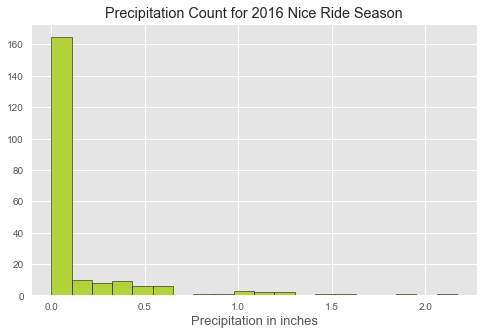

In [103]:
fig = plt.figure(figsize=(8, 5))
plt.gca()
plt.hist(mn_weather.precipitation, bins=20, color='#B2D23A', edgecolor='#000000')
plt.xlabel('Precipitation in inches', fontsize=13)
plt.title('Precipitation Count for 2016 Nice Ride Season');

In [104]:
rainy = mn_weather[mn_weather.precipitation >= 1.0];
print('Days with an inch or more of recorded precipitation: {0}'
      .format(len(rainy)))
v_rainy = mn_weather[mn_weather.precipitation >= 2.0]
print('Days with two or more inches of recorded precipitation: {0}'
      .format(len(v_rainy)))

Days with an inch or more of recorded precipitation: 10
Days with two or more inches of recorded precipitation: 1


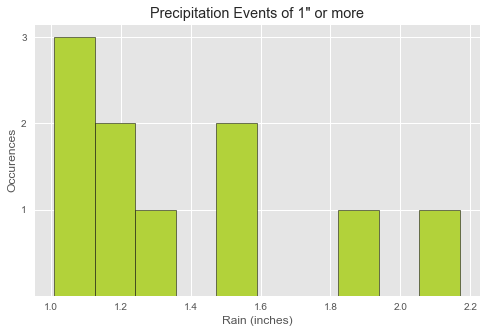

In [105]:
fig = plt.figure(figsize=(8, 5))
plt.gca()
plt.hist(rainy.precipitation, color='#B2D23A', edgecolor='#000000')
plt.yticks([1.0, 2.0, 3.0], ['1', '2', '3'])
plt.ylabel('Occurences')
plt.xlabel('Rain (inches)')
plt.title('Precipitation Events of 1" or more');

**Not enough precipitation in aggregate or precipitation events of significance to plot a linear regression of value.**

### Humidity
> - Relative humidity measures the actual amount of moisture in the air as a percentage of the maximum amount of moisture the air can hold. 
- Humidity % - Absolute humidity is the percentage of water vapor actually present in the air.
- The relative humidity typically ranges from 38% (comfortable) to 89% (very humid) over the course of the year, rarely dropping below 21% (dry) and reaching as high as 99% (very humid).
- The air is driest around April 26, at which time the relative humidity drops below 46% (comfortable) three days out of four; it is most humid around August 21, exceeding 84% (humid) three day
- https://weatherspark.com/averages/30956/Minneapolis-Minnesota-United-States

In [106]:
print('The mean of the daily average humidity of the 2016 season: {:.2f}\n'
      .format(mn_weather.humidity_avg.mean()))
print('The humidity range for the 2016 season - max of {0} and min of {1}.'
      .format(mn_weather.humidity_avg.max(), mn_weather.humidity_avg.min()))

The mean of the daily average humidity of the 2016 season: 64.85

The humidity range for the 2016 season - max of 90 and min of 31.


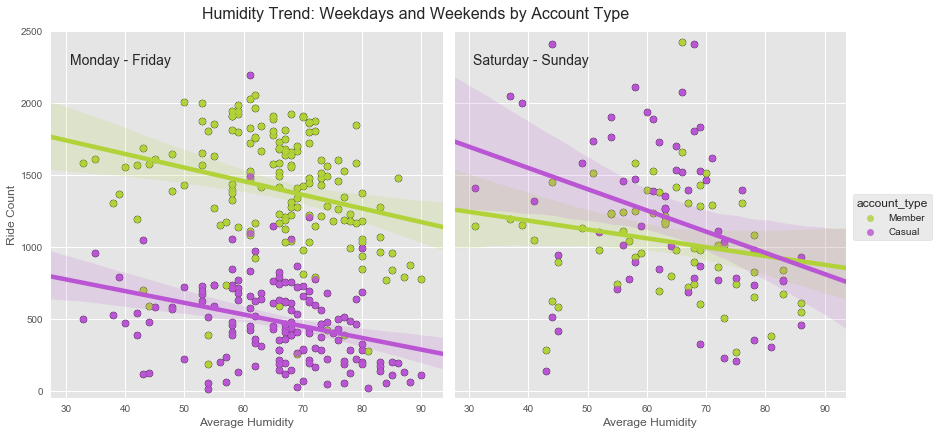

In [107]:
c = dict(Casual='#BA55D3', Member='#B2D23A', set_edgecolor='black')
g = sns.FacetGrid(by_date, col="weekend", hue='account_type',
                  palette=c, hue_order=["Member", "Casual"], size=6)
g.map(plt.scatter, 'humidity_avg', "count", edgecolor="black")
g.map(sns.regplot, 'humidity_avg', 'count')
g.add_legend(frameon=True);
g.axes[0, 0].set_ylim(-50, 2500);
g.axes[0, 0].set_title('')
g.axes[0, 1].set_title('')
g.axes[0, 0].text(0.05, 0.94, 'Monday - Friday', va='top', size=14,
                  transform=g.axes[0, 0].transAxes)
g.axes[0, 1].text(0.05, 0.94, 'Saturday - Sunday', va='top', size=14,
                  transform=g.axes[0, 1].transAxes)
g.fig.text(0.45, 1, "Humidity Trend: Weekdays and Weekends by Account Type",
           ha='center', va='top', size=16);
for ax in g.axes.flat:
    ax.set_xlabel('Average Humidity')
g.axes.flat[0].set_ylabel('Ride Count');
g.fig.savefig('Images/humidity.png', bbox_inches='tight')

### Dew Point
> - Dew Point: the atmospheric temperature (varying according to pressure and humidity) below which water droplets begin to condense and dew can form.
- Dew point is often a better measure of how comfortable a person will find the weather than relative humidity because it more directly relates to whether perspiration will evaporate from the skin, thereby cooling the body. Lower dew points feel drier and higher dew points feel more humid.
- Over the course of a year, the dew point typically varies from -0°F (dry) to 66°F (muggy) and is rarely below -21°F (dry) or above 73°F (very muggy).
- There are two periods in the year that are most comfortable: The first is between May 17 and July 12 and the second is between July 28 and September 28. The air feels neither too dry nor too muggy during these periods.

In [108]:
print('The mean of the daily average dew point of the 2016 season: {:.2f}\n'
      .format(mn_weather.dew_point_avg.mean()))
print('The dew point range for the 2016 season - max of {0} and min of {1}.'
      .format(mn_weather.dew_point_avg.max(), mn_weather.dew_point_avg.min()))

The mean of the daily average dew point of the 2016 season: 50.66

The dew point range for the 2016 season - max of 72 and min of 10.


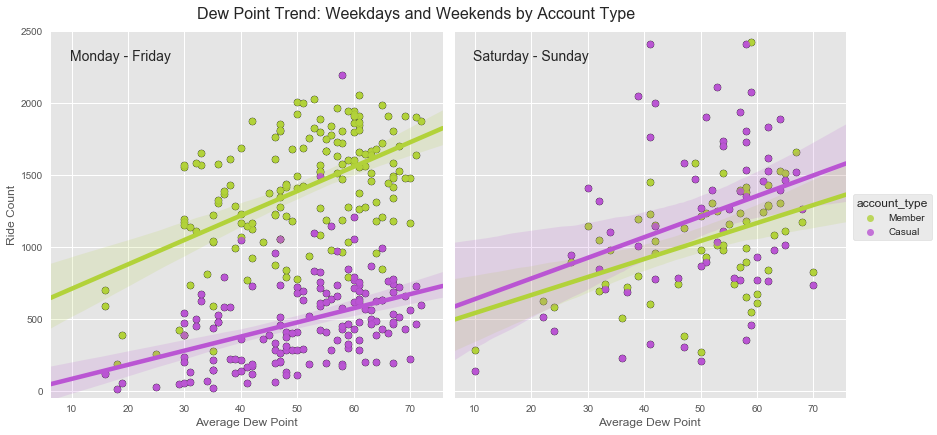

In [109]:
c = dict(Casual='#BA55D3', Member='#B2D23A', set_edgecolor='black')
g = sns.FacetGrid(by_date, col="weekend", hue='account_type',
                  palette=c, hue_order=["Member", "Casual"], size=6)
g.map(plt.scatter, 'dew_point_avg', 'count', edgecolor="black")
g.map(sns.regplot, 'dew_point_avg', 'count')
g.add_legend(frameon=True);
g.axes[0, 0].set_ylim(-50, 2500);
g.axes[0, 0].set_title('')
g.axes[0, 1].set_title('')
g.axes[0, 0].text(0.05, 0.95, 'Monday - Friday', va='top', size=14,
                  transform=g.axes[0, 0].transAxes)
g.axes[0, 1].text(0.05, 0.95, 'Saturday - Sunday', va='top', size=14,
                  transform=g.axes[0, 1].transAxes)
g.fig.text(0.45, 1, "Dew Point Trend: Weekdays and Weekends by Account Type",
           ha='center', va='top', size=16);
for ax in g.axes.flat:
    ax.set_xlabel('Average Dew Point')
g.axes.flat[0].set_ylabel('Ride Count');
g.fig.savefig('Images/dew_point.png', bbox_inches='tight')

### Wind

In [110]:
print('The average fastest 2 min wind speed of the 2016 season: {:.2f}\n'
      .format(mn_weather.wsf2.mean()))
print('The fastest 2 min wind speed for the 2016 season - max of {0} and min of {1}.'
      .format(mn_weather.wsf2.max(), mn_weather.wsf2.min()))

The average fastest 2 min wind speed of the 2016 season: 20.11

The fastest 2 min wind speed for the 2016 season - max of 40.9 and min of 8.9.


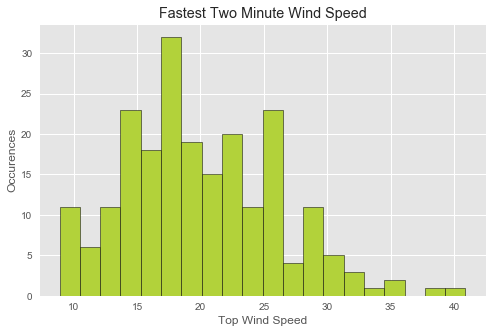

In [111]:
fig = plt.figure(figsize=(8, 5))
plt.gca()
plt.hist(mn_weather.wsf2, bins=20, color='#B2D23A', edgecolor='#000000')
plt.ylabel('Occurences')
plt.xlabel('Top Wind Speed');
plt.title('Fastest Two Minute Wind Speed');

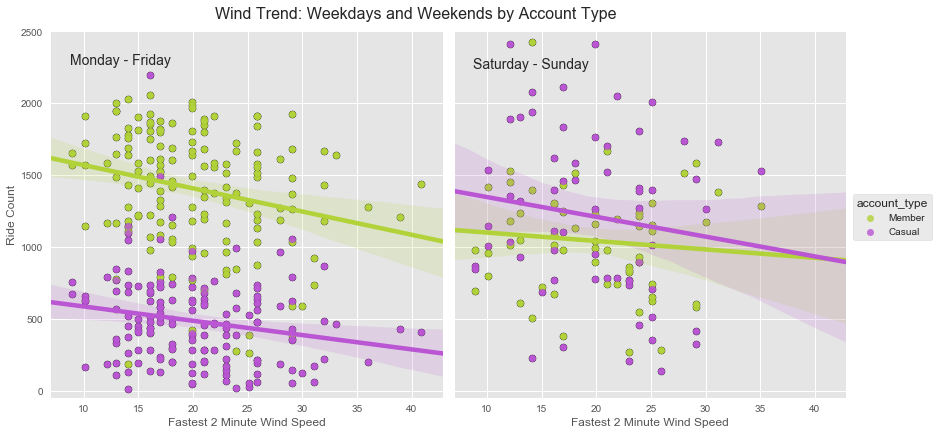

In [112]:
c = dict(Casual='#BA55D3', Member='#B2D23A', set_edgecolor='black')
g = sns.FacetGrid(by_date, col="weekend", hue='account_type',
                  palette=c, hue_order=["Member", "Casual"], size=6)
g.map(plt.scatter, 'wsf2', 'count', edgecolor="black")
g.map(sns.regplot, 'wsf2', 'count')
g.add_legend(frameon=True);
g.axes[0, 0].set_ylim(-50, 2500);
g.axes[0, 0].set_title('')
g.axes[0, 1].set_title('')
g.axes[0, 0].text(0.05, 0.94, 'Monday - Friday', va='top', size=14,
                  transform=g.axes[0, 0].transAxes)
g.axes[0, 1].text(0.05, 0.93, 'Saturday - Sunday', va='top', size=14,
                  transform=g.axes[0, 1].transAxes)
g.fig.text(0.45, 1, "Wind Trend: Weekdays and Weekends by Account Type",
           ha='center', va='top', size=16);
for ax in g.axes.flat:
    ax.set_xlabel('Fastest 2 Minute Wind Speed')
g.axes.flat[0].set_ylabel('Ride Count');
g.fig.savefig('Images/wind.png', bbox_inches='tight')

### Wind Direction
> - http://tornado.sfsu.edu/geosciences/classes/m430/Wind/WindDirection.html
- http://climate.umn.edu/snow_fence/components/winddirectionanddegreeswithouttable3.htm
- https://en.wikipedia.org/wiki/Wind_direction
- Wind direction is usually reported in cardinal directions or in azimuth degrees.<br>For example, a wind coming from the south is given as 180 degrees; one from the east is 90 degrees.

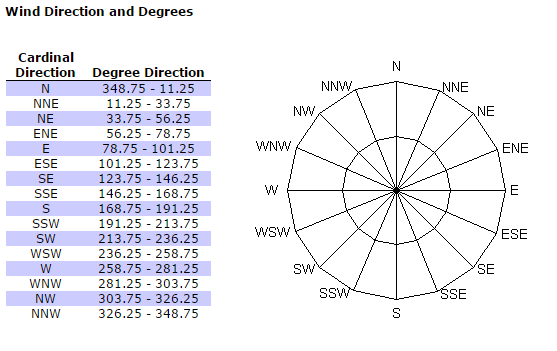

In [113]:
from IPython.display import Image
wind = Image('Images/chart.png'); wind

In [114]:
gust = mn_weather.wdf2.value_counts(); gust.sort_values(ascending=False); gust.head(10)

170    18
310    14
320    12
120    12
180    12
330    10
270    10
80      9
160     9
150     8
Name: wdf2, dtype: int64

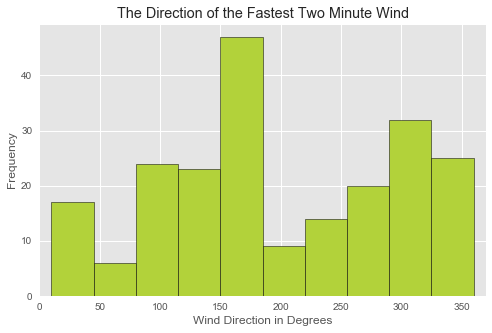

In [115]:
fig = plt.figure(figsize=(8, 5))
plt.gca()
plt.hist(mn_weather.wdf2, color='#B2D23A', edgecolor='#000000')
plt.xlim(0, 370)
plt.ylabel('Frequency')
plt.xlabel('Wind Direction in Degrees')
plt.title('The Direction of the Fastest Two Minute Wind');